<h2>Import the neccessary packages</h2>

In [1]:
import matplotlib.pyplot as plt
from imutils import contours
from imutils.perspective import four_point_transform
import imutils
import numpy as np
import cv2

In [2]:
# define the answer key which maps the question number to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 2, 4: 1}

# a key of 0 indicates the first question, 
# while a value of 1 signifies “B” as the correct answer 
#(since “B” is the index 1 in the string “ABCDE”)

 #index  #Ques  #char  #index
#  0      Q1:     B      1
#  1      Q2:     E      4
#  2      Q3:     A      0
#  3      Q4:     C      2
#  4      Q5:     B      1

<h2>Image Preprocessing</h2>
<ol>
    <li>Read the image</li>
    <li>Convert it to grayscale</li>
    <li>Blur it to hide the details</li>
    <li>Perform edge detection</li>
    <li>Find the contours</li>
</ol>

In [3]:
image = cv2.imread("image7.png") # Read image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray scale image
blurred = cv2.GaussianBlur(gray, (5, 5), 0) # blur image
edged = cv2.Canny(blurred, 75, 200) # detect image 

In [4]:
# function to show the image
def show_image(image):
    cv2.imshow('image',image)
    c = cv2.waitKey()
    if c >= 0 : return -1
    return 1

In [5]:
# show_image(edged)

<h2>Find the outline of the exam paper</h2>

In [6]:
contours= cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
#imutils ==> to use sorting functionality 
cnts = imutils.grab_contours(contours) # contours is the variable in which contours are stored

<h2> Detect exam paper in the whole image </h2>

In [8]:
# ensure that at least one contour was found
document_cnt = None
if len(cnts) > 0:
    # sort the contours according to their area(size) from largest to smallest where paper will have the largest area
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    for c in cnts:
   
        peri = cv2.arcLength(c, True) # Calculating the perimeter
        approx = cv2.approxPolyDP(c, 0.02 * peri, True) # smooth and approximate the quadrilateral.
        
        # If shape has four edges, then paper is found
        if len(approx) == 4:       
            document_cnt = approx
            break
            

In [9]:
# # Show image that demonstrates the document_cnt variable being drawn on the original image
# img = cv2.drawContours(image,[document_cnt],-1,(0,255,0),2)
# show_image(img)

In [10]:
# plt.imshow(img) # Another way to show the image

<h2>Applying four point transformation</h2>

In [11]:
# Crop the unused area
paper = four_point_transform(image, document_cnt.reshape(4, 2))
warped = four_point_transform(gray, document_cnt.reshape(4, 2))

In [12]:
# show_image(paper)

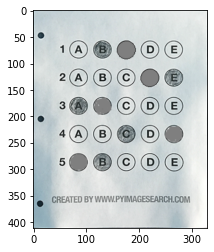

In [13]:
plt.imshow(paper)

In [14]:
# show_image(warped)

<h2>Apply Binary Thresholding</h2>
<ul>
    <li>Apply OTSU's thresholding method to binarize the warped piece of paper.
        <ul><li>If the pixel value is smaller than the threshold (in our case thresh=0), set it to 0.</li>
            <li>Otherwise it is set to a maximum value(255).</li>
        </ul>
    </li>
</ul>
        

In [15]:
# This converts the image to black and white
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

In [16]:
# show_image(thresh)

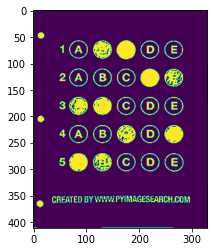

In [17]:
 plt.imshow(thresh)

<h2>Finding the contours of the thresholded image</h2>

In [18]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

<h2>Determining the contours of the bubble</h2>

In [19]:
questionContours = []

# loop over the contours
for c in cnts:
    
    (x, y, w, h) = cv2.boundingRect(c)        # compute the bounding box of the bubble
    ar = w / float(h)                         # compute the ratio of the width to the height
    # print(ar, h, w)
    if w >= 30 and h >= 30 and ar >= 0.9 and ar <= 1.1:
        questionContours.append(c)
    

In [20]:
len(questionContours)

25

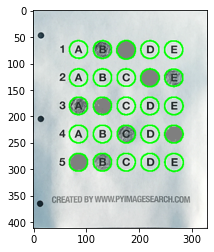

In [21]:
# Visualizing the contour of bubbles
img2 = cv2.drawContours(paper.copy(),questionContours,-1,(0,255,0),2)
plt.imshow(img2)

<h2>Sorting the question contours from top to bottom</h2>

In [22]:
from imutils import contours
questionContours = contours.sort_contours(questionContours, method="top-to-bottom")[0]

<h2>Work with each bubble</h2>

In [23]:
p = paper.copy()
correct = 0

for (q, i) in enumerate(np.arange(0, len(questionContours), 5)):
    
    cnts = contours.sort_contours(questionContours[i:i+5], method="left-to-right")[0]
    bubbled = None
    flag = False

    for (j, c) in enumerate(cnts):
        
        mask = np.zeros(thresh.shape, dtype="uint8")
        cv2.drawContours(mask, [c], -1, 255, -1)
        
        mask = cv2.bitwise_and(thresh, thresh, mask=mask)
        total = cv2.countNonZero(mask) 
        
        # check if another bubble found in the same question, if so then set bubbled to None & break the loop
        if flag and total > 600:
            bubbled = None          
            break
            
        if total > 600:
            flag = True
            bubbled = (total, j)
            
            
    color = (0, 0, 255)
    
    k = ANSWER_KEY[q]
    
    if bubbled and k == bubbled[1]:
        color = (0, 255, 0)
        correct += 1
        
    # draw outline for either the correct or the wrong answer on the test
    cv2.drawContours(p, [cnts[k]], -1, color, 3)

<h2>Displaying Results</h2>

In [ ]:
print("Result: ", correct, "/", len(cnts))
score = (correct / (q+1)) * 100
print("score: {:.2f}%".format(score))
cv2.putText(p, "{:.2f}%".format(score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.imshow("Original", image)
cv2.imshow("Exam", p)
cv2.waitKey(0)

Result:  0 / 5
score: 0.00%
